In [ ]:
import tensorflow as tf
import numpy as np
import io
import chess.pgn
import zstandard as zstd
import re

from bitboard import bitboard_to_array, bitboards_to_3d_array, board_to_bitboards, array_to_bitboard, bitboards_to_board

# Define a dictionary to map the color values to nice output strings
color_names = {
    chess.WHITE: "w",
    chess.BLACK: "b"
}

def data_generator_batch(batch_size):
    with open('./data/lichess_db_standard_rated_2023-06.pgn.zst', 'rb') as f:
        dctx = zstd.ZstdDecompressor()
        reader = dctx.stream_reader(f)
        text_stream = io.TextIOWrapper(reader, encoding='utf-8')
        
        # Initialize lists to store batch data
        batch_boards = []
        batch_move_numbers = []
        batch_evals = []
        batched_so_far = 0 # when this gets to 32, yield the batched data and reset to 0
        # Iterate over all games in the PGN file
        while True:
            number_of_games = 0
            
            game = chess.pgn.read_game(text_stream)
            if game is None:
                break
            
            # Check if the game has embedded Stockfish evaluations
            has_evaluations = any('[%eval ' in node.comment for node in game.mainline())
            if not has_evaluations:
                #print("found game with no eval")
                continue

            #print(game)
            
            number_of_games += 1
            
            # Count the number of moves in the main line
            num_moves = sum(1 for _ in game.mainline_moves())
            
            # Setup initial empty chess board
            board = chess.Board()
            
            # Iterate through all moves of the game
            for node in game.mainline():
                move = node.move
                board.push(move)

                # Get the comment (which contains the evaluation) for this move
                comment = node.comment
                match = re.search(r"\[%eval (.*?)\]", comment)
                if match is None:
                    #print(f"did not find a match when one was expected.")
                    continue
                
                score_str = match.group(1)
                
                # Convert mate in 'n' moves to large scores
                if '#' in score_str:
                    if '-' in score_str:
                        score = -1000
                    else:
                        score = 1000
                else:
                    score = float(score_str)
                
                # Convert the board position to bitboards and add to list
                bitboards = board_to_bitboards(board)
                batch_boards.append(bitboards_to_3d_array(bitboards))
                batch_move_numbers.append(np.int16(board.ply()))
                batch_evals.append(np.float16(score))
                batched_so_far += 1
                try:
                    assert(len(batch_boards) == batched_so_far)
                    assert(len(batch_move_numbers) == batched_so_far)
                    assert(len(batch_evals) == batched_so_far)
                except Exception as e:
                    print("These should match", e)
                    
                #print(f"game: {number_of_games} move: {board.ply()}/{num_moves} {move.uci()} next: {color_names[np.int32(board.turn)]} score: {np.float16(score)}")
                #print(board)
                if batched_so_far == batch_size:
                    batched_so_far = 0
                    # print(f"batch_size: {batch_size}")
                    # print(f"len(batch_boards): {len(batch_boards)}")
                    # print(f"len(batch_move_numbers): {len(batch_move_numbers)}")
                    # print(f"len(batch_evals): {len(batch_evals)}")
                    # Convert batch data to numpy arrays
                    batch_boards = np.array(batch_boards, dtype=np.int16)
                    batch_move_numbers = np.array(batch_move_numbers, dtype=np.int16)
                    batch_evals = np.array(batch_evals, dtype=np.float16)
                    # Yield batch data
                    yield ((batch_boards, batch_move_numbers), batch_evals)
                    # Initialize lists to store batch data
                    batch_boards = []
                    batch_move_numbers = []
                    batch_evals = []
  

# Use batch generator to create dataset
batch_size = 32
dataset = tf.data.Dataset.from_generator(
    lambda: data_generator_batch(batch_size),  # Change 32 to the batch size you want
    output_signature=(
        (tf.TensorSpec(shape=(None, 12, 8, 8), dtype=tf.int8),
         tf.TensorSpec(shape=(None,), dtype=tf.int16)),
        tf.TensorSpec(shape=(None,), dtype=tf.float16)
    )
)

In [ ]:
for input, scores in dataset.take(3):
    print("+++++++++++++++++++++++++++++++++++++++++++")
    batch_of_arrays = input[0].numpy().tolist()
    moves = input[1].numpy().tolist()
    scores = scores.numpy().tolist()
    for arrays, move, score in zip(batch_of_arrays, moves, scores):
        print("xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx")
        bitboards = [array_to_bitboard(array) for array in arrays]
        board = bitboards_to_board(bitboards)
        print(board)
        print(f"move: {move} score: {score}")

In [6]:
n_data = 100
dataset_subset = dataset.take(n_data)

In [4]:
from tensorflow.keras import layers

# input shape for the board is 12x8x8
board_input = layers.Input(shape=(12, 8, 8))

# input for the move number is a single scalar
move_number_input = layers.Input(shape=(1,))

# Add several convolutional layers to process the board
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(board_input)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Flatten()(x)
# Concatenate the processed board and move number inputs
x = layers.Concatenate()([x, move_number_input])  # move_number_input is directly used here

# Add more fully-connected layers
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
# Add an output layer, assuming we're doing regression to predict the evaluation score
output_layer = layers.Dense(1)(x)

# Create the model
model = tf.keras.Model(inputs=(board_input, move_number_input), outputs=output_layer)

# Compile the model, using mean squared error as the loss function for regression
model.compile(optimizer='adam', loss='mse')

Epoch 1/100
     98/Unknown - 2s 18ms/step - loss: 72614.2812

2023-07-31 02:28:07.947656: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 4464803556083464795
2023-07-31 02:28:08.070351: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1510195200 exceeds 10% of free system memory.


100/100 [==============================] - 2s 22ms/step - loss: 71473.0938
Epoch 2/100
 98/100 [============================>.] - ETA: 0s - loss: 71646.5938

2023-07-31 02:28:10.346718: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1510195200 exceeds 10% of free system memory.


100/100 [==============================] - 2s 23ms/step - loss: 70528.5703
Epoch 3/100
 98/100 [============================>.] - ETA: 0s - loss: 73132.6875

2023-07-31 02:28:12.557035: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1510195200 exceeds 10% of free system memory.


100/100 [==============================] - 2s 22ms/step - loss: 71998.9062
Epoch 4/100
 99/100 [============================>.] - ETA: 0s - loss: 66030.3359

2023-07-31 02:28:14.989309: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1510195200 exceeds 10% of free system memory.


100/100 [==============================] - 2s 24ms/step - loss: 65677.5781
Epoch 5/100
100/100 [==============================] - 2s 24ms/step - loss: 48743.5156
Epoch 6/100
100/100 [==============================] - 2s 23ms/step - loss: 41724.6875
Epoch 7/100
100/100 [==============================] - 2s 22ms/step - loss: 26544.8496
Epoch 8/100
100/100 [==============================] - 2s 23ms/step - loss: 34920.2266
Epoch 9/100
100/100 [==============================] - 2s 22ms/step - loss: 41216.3828
Epoch 10/100
100/100 [==============================] - 2s 22ms/step - loss: 41887.2227
Epoch 11/100
100/100 [==============================] - 2s 23ms/step - loss: 52058.3008
Epoch 12/100
100/100 [==============================] - 2s 24ms/step - loss: 35021.3281
Epoch 13/100
100/100 [==============================] - 2s 23ms/step - loss: 40735.1719
Epoch 14/100
100/100 [==============================] - 3s 25ms/step - loss: 64296.8594
Epoch 15/100
100/100 [============================

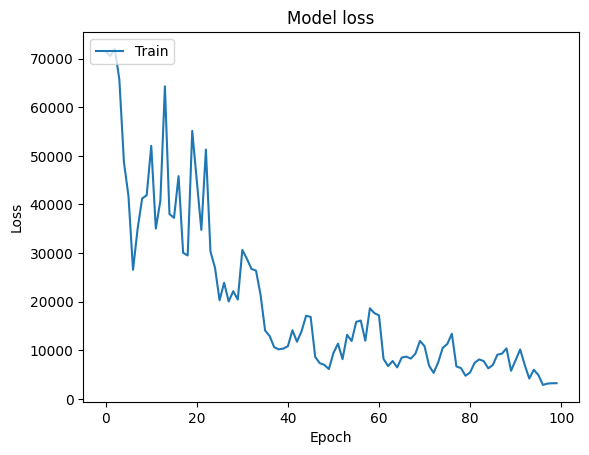

In [7]:
tb_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs", histogram_freq=1)

epochs = 100

history = model.fit(dataset_subset, epochs=epochs, callbacks=[tb_callback])  # adjust epochs according to your need
# Plot training & validation loss values
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

In [8]:
model.save_weights(f"./data/my_model-{epochs}-{n_data}-{batch_size}.keras")
model.save(f"./data/my_model-{epochs}-{n_data}-{batch_size}.h5")

/home/jerry/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:


history = model.fit(dataset_subset, epochs=epochs+1, callbacks=[tb_callback])  # adjust epochs according to your need
# Plot training & validation loss values
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()
model.save_weights(f"./data/my_model-{epochs+1}-{n_data}-{batch_size}.keras")
model.save(f"./data/my_model-{epochs+1}-{n_data}-{batch_size}.h5")

In [ ]:
model.save_weights(f"./data/my_model-{epochs+1}-{n_data}-{batch_size}.keras")
model.save(f"./data/my_model-{epochs+1}-{n_data}-{batch_size}.h5")